In [ ]:
# 2019A 2)结果

In [91]:
import numpy as np
from functools import lru_cache

@lru_cache(maxsize=None)
def rho(p):
    return (0.85 * p - 85.0) / (1.0 / (np.exp(90100664/13926267 + 3367307*p/501847788) - 1.0) - p + 1005.6) + 0.85

# bisect for p, p should be in range of [1, 200]
@lru_cache(maxsize=None)
def p(rho_p, eps=1e-10):
    p_low = 0
    p_high = 200.0
    while True:
        p_mid = (p_low + p_high) / 2.0
        # print("Trying:", p_mid)
        rho_mid = rho(p_mid)
        if abs(p_mid - p_low) < eps or abs(p_mid - p_high) < eps:
            raise Exception("p not found")
        if abs(rho_mid - rho_p) < eps:
            return p_mid
        elif rho_mid < rho_p:
            p_low = p_mid
        else:
            p_high = p_mid

In [92]:
import pandas as pd

In [93]:
rotations = pd.read_excel("./附件1-凸轮边缘曲线.xlsx")

In [94]:
eps_strict = 1e-10

In [95]:
rotations.head()

,theta,r
0,0.00,7.2390
1,0.01,7.2389
2,0.02,7.2385
3,0.03,7.2379
4,0.04,7.2371


In [96]:
l_theta = pd.DataFrame({
    "theta": rotations["theta"],
    "l": np.max(rotations["r"]) - rotations["r"]
})

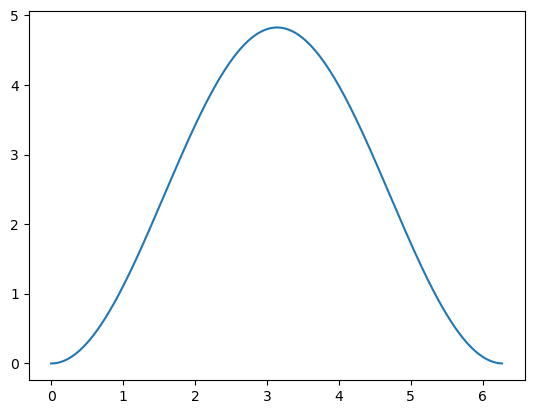

In [97]:
import matplotlib.pyplot as plt

plt.plot(l_theta["theta"], l_theta["l"])

In [98]:
import numpy as np
from scipy.optimize import curve_fit

# Define the function to fit
def func(x, *coeffs):
    return sum([coeffs[i] * x**i for i in range(len(coeffs))])

# Fit the function to the data
popt, pcov = curve_fit(func, l_theta["theta"], l_theta["l"], p0=np.ones(12))

# Print the parameters of the fitted function
print(popt)

[-2.27424445e-05  5.66505005e-04  1.20339710e+00  7.16348840e-03
 -1.09432643e-01  6.66970945e-03  1.40599284e-04  1.01762498e-03
 -2.71298814e-04  2.74806548e-05 -1.23618603e-06  1.99508036e-08]


In [99]:
# calculate the loss
l_theta["l_fit"] = func(l_theta["theta"], *popt)
l_theta["loss"] = l_theta["l"] - l_theta["l_fit"]
print("loss:", np.sum(l_theta["loss"]**2) / len(l_theta))

loss: 8.00723711359767e-10


In [100]:
def a_extra_length(theta):
    return func(theta, *popt)

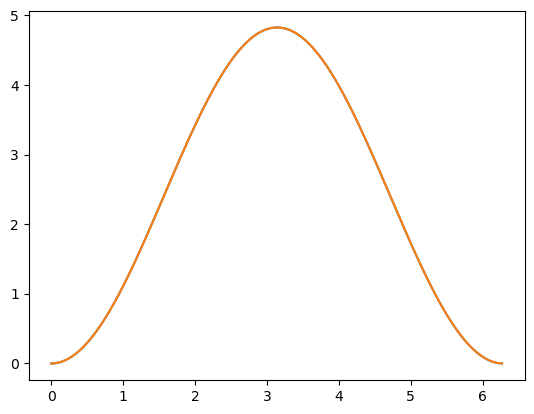

In [101]:
# plot the fitted function

plt.plot(l_theta["theta"], l_theta["l"])
plt.plot(l_theta["theta"], a_extra_length(l_theta["theta"]))

In [102]:
A_con_area = np.pi * (5 / 2) ** 2

In [103]:
@lru_cache(maxsize=None)
def get_A_vol(theta):
    return A_con_area * a_extra_length(theta) + 20

In [104]:
displacement = pd.read_excel("./附件2-针阀运动曲线.xlsx")
displacement.head()

,t,d
0,0.00,0.000000
1,0.01,0.000001
2,0.02,0.000020
3,0.03,0.000100
4,0.04,0.000316


In [105]:
deg9 = np.pi * 9 / 180
C = 0.85
p_atm = 0.1

@lru_cache(maxsize=None)
def get_out_area(t: float):
    t %= 100
    if t >= 2.45:
        return 0
    base_area = np.pi * (1.4 / 2) ** 2
    ring_area = np.pi * ((displacement["d"][int(t * 100)]) * np.tan(deg9) + 0.7) ** 2 - base_area
    return np.min([ring_area, base_area])

@lru_cache(maxsize=None)
def get_out_mass_flow(t: float, p_container: float, rho_container: float):
    t %= 100
    if t >= 2.45:
        return 0
    return C * get_out_area(t) * np.sqrt(2 * (p_container - p_atm) * rho_container)

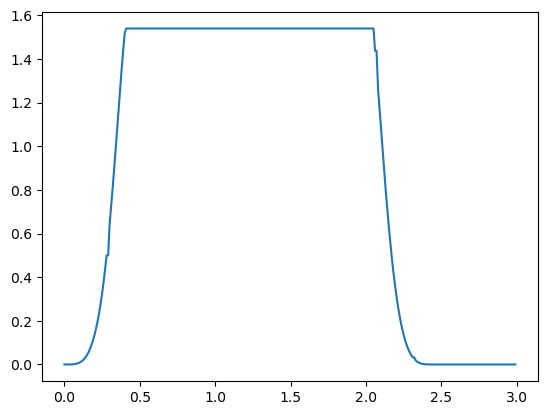

In [106]:
# plot the out area
plt.plot(np.arange(0, 3, 0.01), [get_out_area(t) for t in np.arange(0, 3, 0.01)])

In [107]:
get_out_mass_flow(1.8, 100, 1)

18.495352819477684

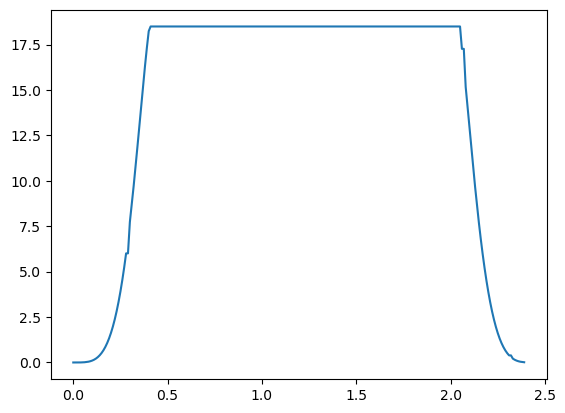

In [108]:
plt.plot(np.arange(0, 2.4, 0.01), [get_out_mass_flow(t, 100, 1) for t in np.arange(0, 2.4, 0.01)])

In [109]:
T = 100e3
dt = 1e-2
N = int(T / dt)

In [110]:
container_vol = 500 * (10 / 2) ** 2 * np.pi
container_vol

39269.90816987241

In [111]:
mass_into_A = rho(0.5) * get_A_vol(3.14)
mass_into_A

87.88804158314946

In [112]:
A_in_area = np.pi * (1.4 / 2) ** 2

In [113]:
eps_strict

1e-10

In [114]:
eps_relaxed = 1e-4
eps = 1e-6

In [115]:
get_A_vol(0) / get_A_vol(3.14)

0.1742756261412382

In [116]:
@lru_cache(maxsize=None)
def cal(angular_vel):
    # rad/s
    period_count = int((6.28 / angular_vel) / dt)
    mass_A = np.ndarray(N)
    mass_A.fill(rho(100) * 20)
    mass_container = np.ndarray(N)
    mass_container.fill(0.85 * container_vol)
    for t_ in range(1, N):
        # if t_ % (N // 4) == 0:
        #     print(t_ / N, end="\t")
        mass_A[t_] = mass_A[t_ - 1]
        mass_container[t_] = mass_container[t_ - 1]
        if t_ % period_count == int(period_count // 2):
            # print("period:", t_ / N)
            mass_A[t_] = mass_into_A
        theta = angular_vel * t_ * dt
        rho_A = mass_A[t_ - 1] / get_A_vol(theta % 6.28)
        rho_container = mass_container[t_ - 1] / container_vol
        dif = 0
        if rho_A - rho_container > 0:
            flow = C * A_in_area * np.sqrt(2 * (p(rho_A) - p(rho_container)) * rho_A)
            mass_A[t_] -= flow * dt
            dif += flow
        dif -= get_out_mass_flow(t_ * dt, p(rho_container), rho_container)
        mass_container[t_] += dif * dt
    return mass_A, mass_container

In [117]:
# use gradient descent to find the best angular velocity
def cal_loss(m_c):
    nn = len(m_c)
    m_c_smooth = np.convolve(m_c, np.ones(1000) / 1000, mode="same")
    return np.sum((m_c_smooth[int(nn * 99 // 100):] / container_vol - 0.85) ** 2)

current_val = 0.02785
current_loss = 1e10

iterations_cnt = 0
learning_rate = 1e-8

def loss_grad(angular_vel):
    eps = 1e-6
    m_a, m_c = cal(angular_vel)
    loss = cal_loss(m_c)
    m_a_, m_c_ = cal(angular_vel + eps)
    loss_ = cal_loss(m_c_)
    return (loss_ - loss) / eps

for i in range(iterations_cnt):
    # print("iter:", i, "angular_vel:", current_val, "loss:", current_loss)
    m_a, m_c = cal(current_val)
    current_loss = cal_loss(m_c)
    current_val -= learning_rate * loss_grad(current_val)
    print("iter:", i, "angular_vel:", current_val, "loss:", current_loss)

In [118]:
mass_A, mass_container = cal(current_val)

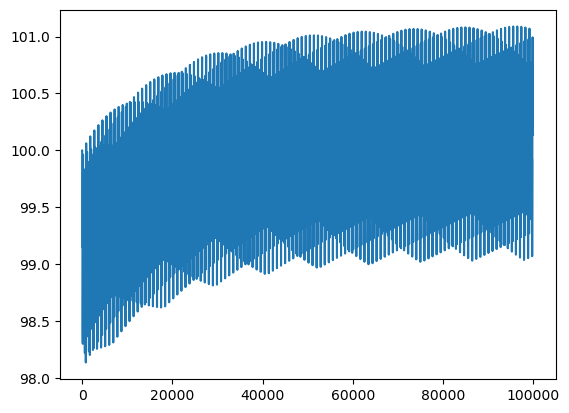

In [119]:
# Plot the result
plt.plot(np.arange(0, T, dt), [p(a) for a in mass_container / container_vol])

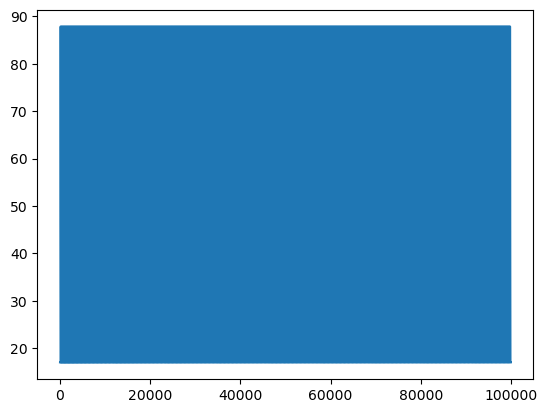

In [120]:
plt.plot(np.arange(0, T, dt), mass_A)